<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

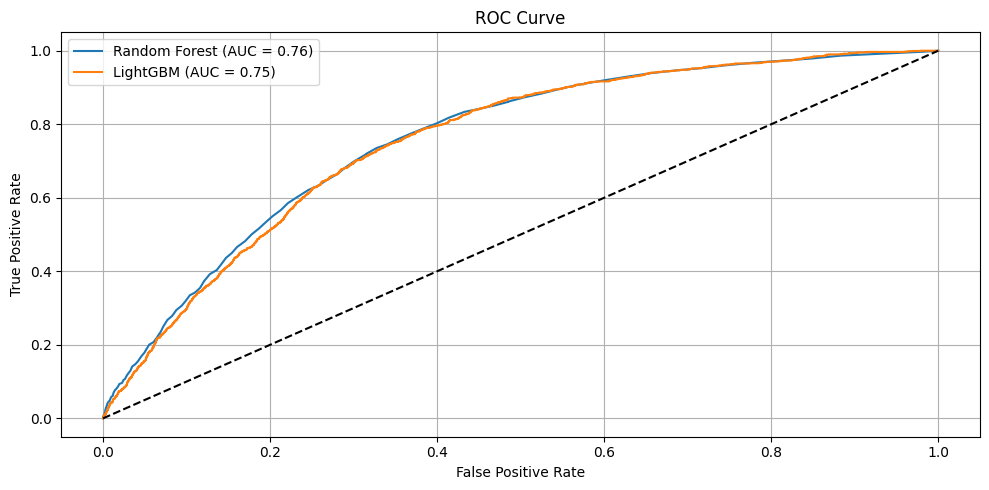

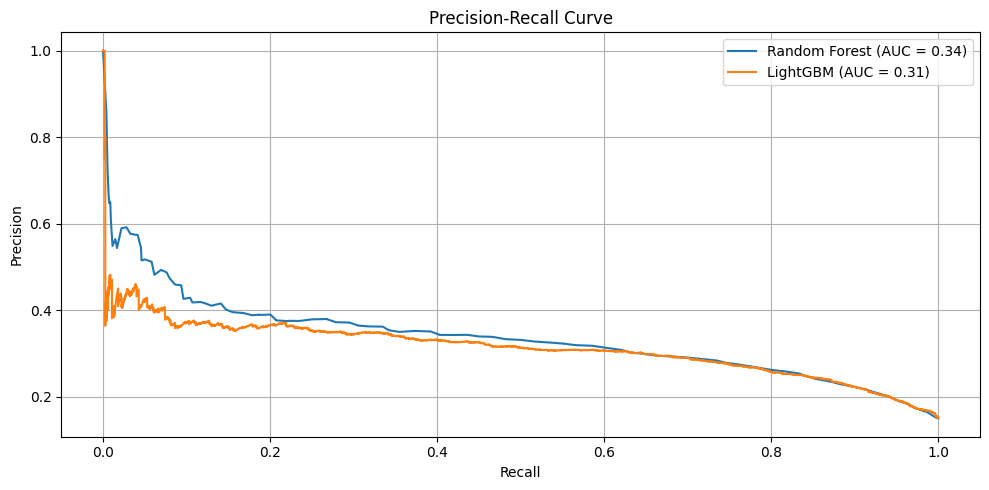

In [2]:
# booking_prediction_comparison.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# 1. Load and preprocess data
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.info()

# Drop ID if exists
df.drop(columns=[col for col in df.columns if "reference" in col.lower()], inplace=True)

# Label encode categorical
le = LabelEncoder()
for col in df.select_dtypes("object"):
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Apply SMOTE to train data only
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# 3. Train Random Forest
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train_sm, y_train_sm)
rf_proba = rf.predict_proba(X_test)[:, 1]

# 4. Train LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train_sm, y_train_sm)
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]

# 5. Threshold tuning
threshold = 0.3
rf_pred_adj = (rf_proba >= threshold).astype(int)
lgbm_pred_adj = (lgbm_proba >= threshold).astype(int)

# 6. Evaluation Function
def evaluate_model(name, y_true, y_proba, y_pred_adj):
    print(f"\n📊 {name} (Threshold {threshold})")
    print(classification_report(y_true, y_pred_adj))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_adj))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

evaluate_model("Random Forest", y_test, rf_proba, rf_pred_adj)
evaluate_model("LightGBM", y_test, lgbm_proba, lgbm_pred_adj)

# 7. Plot ROC and PR curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_proba)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_proba)
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, lgbm_proba)

# ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_proba):.2f})")
plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC = {roc_auc_score(y_test, lgbm_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AUC = {auc(recall_rf, precision_rf):.2f})")
plt.plot(recall_lgbm, precision_lgbm, label=f"LightGBM (AUC = {auc(recall_lgbm, precision_lgbm):.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

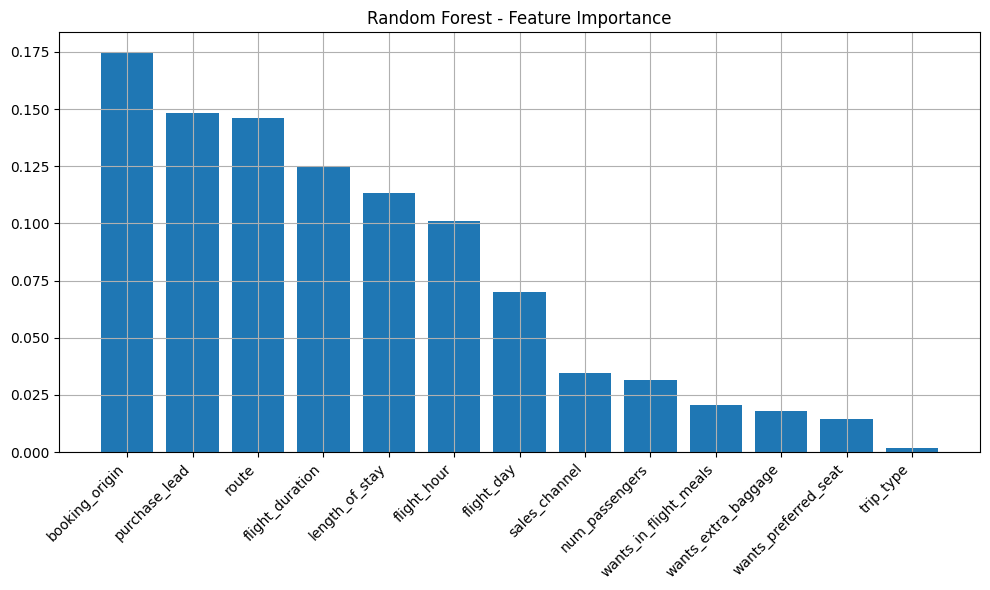

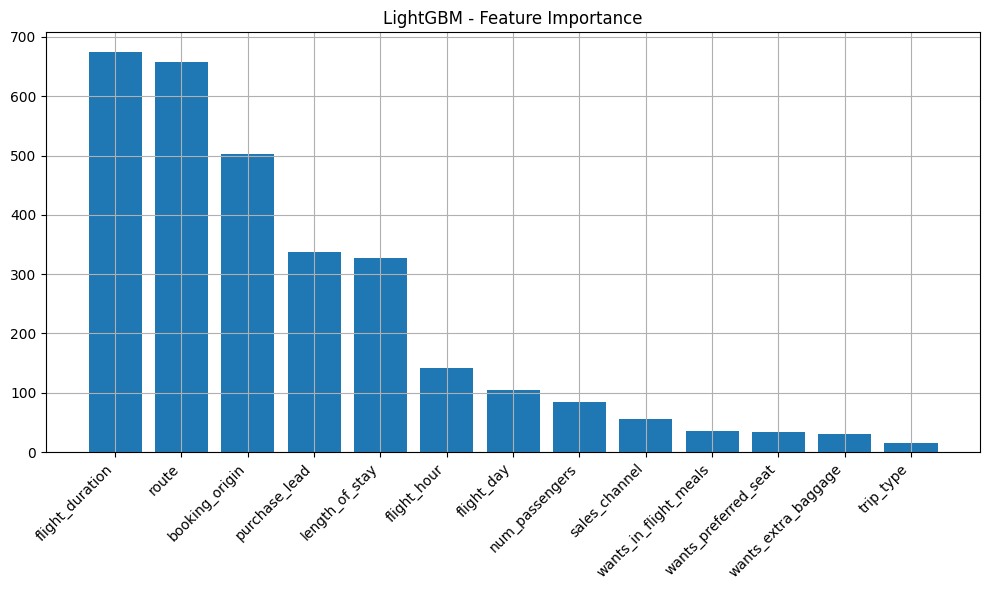

In [3]:
# 8. Feature Importance
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"{model_name} - Feature Importance")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_feature_importance(rf, "Random Forest", X.columns)
plot_feature_importance(lgbm, "LightGBM", X.columns)